DQN cartpole-v1 environment

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np
import time
import random

In [2]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(4,512)
        self.fc_q = nn.Linear(512,2)
        self.optimizer = optim.Adam(self.parameters(), lr=0.0003)
    
    def Q(self, x):
        x = F.relu(self.fc1(x))
        q = self.fc_q(x)
        return q
    
    def train(self, loss):
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()

In [3]:
env = gym.make('CartPole-v1')
model = DQN()
model.cuda()
GAMMA = 0.98
EPSILON = 0.1
BATCH_SIZE = 32
N = 30000 ## reply memory size
replay_memory = []

In [4]:
def epsilon_greedy(Q, eps, action_dim):
    if random.random() < eps:
        action = random.randint(0, action_dim-1)
    else:
        action = torch.argmax(Q).item()
    return action

def store_transition(s, a, r, s_prime, done):
    if len(replay_memory) == N:
        del(replay_memory[0])
    replay_memory.append((s, a, r, s_prime, done))
    
def training():
    s_list, r_list, a_list, s_p_list, done_list = [], [], [], [], []
    mini_batch = random.sample(replay_memory, BATCH_SIZE)
    for sample in mini_batch:
        s_list.append(sample[0].unsqueeze(0))
        s_p_list.append(sample[3].unsqueeze(0))
        r_list.append([sample[2]])
        a_list.append([sample[1]])
        done_list.append([0]) if sample[-1] else done_list.append([1])
    s = torch.cat(s_list, dim=0)
    s_p = torch.cat(s_p_list, dim=0)
    a = torch.tensor(a_list).cuda().reshape(-1,1)
    r = torch.tensor(r_list, dtype=torch.float).cuda().reshape(-1,1)
    done_mask = torch.tensor(done_list, dtype=torch.float).cuda().reshape(-1,1)
    
    cur_Q = model.Q(s)
    next_Q = model.Q(s_p)
    td_target = r + GAMMA*torch.max(next_Q, dim=1)[0].reshape(-1,1)*done_mask
    loss = (td_target - cur_Q.gather(1,a)).pow(2).mean()
    model.train(loss)

def test_agent():
    reward_sum = 0.0
    for ep in range(10):
        observation = env.reset()
        while True:
            state = torch.tensor(observation, dtype=torch.float).cuda()
            action = torch.argmax(model.Q(state))
            observation, reward, done, _ = env.step(action.item())
            reward_sum += reward
            if done: break
    return reward_sum/10.0

In [5]:
reward_list = []

for ep in range(1500):
    observation = env.reset()
    while True:
        state = torch.tensor(observation, dtype=torch.float).cuda()
        action = epsilon_greedy(model.Q(state), EPSILON, 2)
        observation, reward, done, _ = env.step(action)
        next_state = torch.tensor(observation, dtype=torch.float).cuda()
        store_transition(state, action, reward, next_state, done)
        if len(replay_memory) > 1000:
            training()
        if done:
            break
            
    if ep % 100 == 99:
        test_reward = test_agent()
        print('Episode %d'%ep,', Greedy action reward : %f'%(test_reward))
        reward_list.append(test_reward)
env.close()

Episode 99 , Greedy action reward : 9.400000
Episode 199 , Greedy action reward : 9.500000
Episode 299 , Greedy action reward : 45.800000
Episode 399 , Greedy action reward : 52.500000
Episode 499 , Greedy action reward : 55.300000
Episode 599 , Greedy action reward : 66.000000
Episode 699 , Greedy action reward : 46.900000
Episode 799 , Greedy action reward : 52.600000
Episode 899 , Greedy action reward : 79.300000
Episode 999 , Greedy action reward : 82.800000
Episode 1099 , Greedy action reward : 83.100000
Episode 1199 , Greedy action reward : 256.100000
Episode 1299 , Greedy action reward : 141.000000
Episode 1399 , Greedy action reward : 135.600000
Episode 1499 , Greedy action reward : 500.000000


Learning curve

10 game mean score every 100 episode

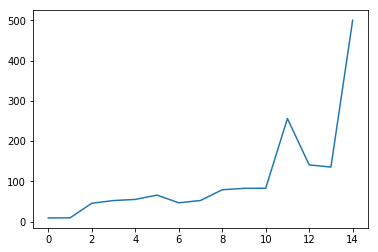

In [6]:
plt.plot(reward_list)
plt.show()

Test rendering

In [7]:
for ep in range(10):
    observation = env.reset()
    while True:
        time.sleep(0.05)
        env.render()

        state = torch.tensor(observation, dtype=torch.float).cuda()
        action = torch.argmax(model.Q(state))
        observation, reward, done, _ = env.step(action.item())
        if done: break
env.close()